<a href="https://colab.research.google.com/github/nuvvulapraveen17/MachineLearning-DeepLearning/blob/main/WordEmbeddings/WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embeddings

We will implement a famous model called the **continuous bag of words (CBOW) model.**

When we have text kind of data to learn/represent a mathematical function or machine learning algorithm, first we need a way of converting the
input data to a vector x.

One very simple way of doing this is
to use **one-hot vectors** of size Vocabulary, But these are sparse and dont have the notion of capturing the similarity between words.

Distributed representation of words also called termed as **Word Embeddings** -> of which one is CBOW model.

# 1.The Continuous bag of words model

Let's take a look at the following sentence:

> 'I am happy because I am learning'.

* In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
* For example, if you were to choose a context half-size of say  C=2 , then you would try to predict the word happy given the context that includes 2 words before and 2 words after the center word:

> C  words before: [I, am] <br> C  words after: [because, I]

* In other words:

<center>$context=[I,am,because,I]$</center> 
<center>$target=happy$</center>

The structure of your model will look like this
![](https://raw.githubusercontent.com/nuvvulapraveen17/ImagesForColab/main/image1.png)
Figure1

Where $\bar{x}$ is the average of all the one hot vectors of the context words.

![](https://raw.githubusercontent.com/nuvvulapraveen17/ImagesForColab/main/imag2.png)
Figure 2

Once we have encoded all the context words, we can use $\bar{x}$ as the input to your model.

The architecture you will be implementing is as follows:

<center>$h = W_1X + b_1$</center>
<center>$a = ReLU(h)$</center>
<center>$z = W_2a + b_2$</center>
<center>$\hat{y} = softmax(z)$</center>

In [2]:
# lets write some helper functions which we will use later
import numpy as np
from scipy import linalg
from collections import defaultdict


def sigmoid(z):
    # sigmoid function
    return 1.0/(1.0+np.exp(-z))

# given a context(words) lets its indexes
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx


def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed


def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0


def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch = []


def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    ### START CODE HERE ###
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    ### END CODE HERE ###
    return np.dot(evecs.T, data.T).T


def get_dict(data):
    """
    Input:
        K: the number of negative samples
        data: the data you want to pull from
        indices: a list of word indices
    Output:
        word_dict: a dictionary with the weighted probabilities of each word
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    
    #words = nltk.word_tokenize(data)
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    # return these correctly
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [3]:
# Import Python libraries
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter

In [4]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [6]:
# we need punkt for tokenizing
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
# Load, tokenize and pre-process the data
# we regulae expressions(re) module
import re                                                           #  Load the Regex-modul
with open('shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60933 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [14]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  5772
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1252), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('you', 748), ('a', 742), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


**Mapping words to indices and indices to words**

We will use our helper function to create a dictionary that maps words to indices and indices to words.

In [15]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5772


In [16]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2743
Word which has index 2743:   king


# 2.Training the Model

**Initializing the model**

we will now initialize two matrices and two vectors.

* The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.

* The second matrix ($W_2$) is of dimension $V \times N$.

* Vector $b_1$ has dimensions $N \times 1$.
* Vector $b_2$ has dimensions $V \times 1$.
* $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters.

In [17]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)

    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)

    return W1, W2, b1, b2

**2.1 Softmax function**

<center>$softmax(z_i) = \frac{e^{z_i}}{\sum_{i=0}^{V-1}e^{z_i}}$</center>

In [18]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    
    # Calculate yhat (softmax)
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    
    return yhat

**2.2 Forward Propagation**

<center>$h = W_1X + b_1$</center>
<center>$a = ReLU(h)$</center>
<center>$z = W_2a + b_2$</center>

We will use as activation the Rectified Linear Unit (ReLU) given by:

<center>$f(h) = max(0, h)$</center>

In [19]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    # Calculate h
    h = np.dot(W1,x)+b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)
    
    # Calculate z
    z = np.dot(W2,h)+b2
    
    return z, h

**2.3 Cost function**

We will use already implemented cross-entropy cost function in helper functions section

In [20]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

**2.4 Training the Model - Backpropagation**


In [21]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    grad_W1 = (1/batch_size)*np.dot(l1,x.T)    #1/m * relu(w2.T(yhat-y)) . xT
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    # Compute the gradient of b1
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    # Compute the gradient of b2
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

# Gradient Descent

We have implemented a function to compute the gradients, we will implement batch gradient descent over our training set.

**Hint:** For that, you will use **initialize_model** and the **back_prop** functions which we just created (and the compute_cost function).

we will also print the cost after each batch is processed (**batch size = 128**)

In [22]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
      
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [23]:
# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.106936
iters: 20 cost: 0.040204
iters: 30 cost: 0.024862
iters: 40 cost: 0.018015
iters: 50 cost: 0.014132
iters: 60 cost: 0.011629
iters: 70 cost: 0.009881
iters: 80 cost: 0.008591
iters: 90 cost: 0.007599
iters: 100 cost: 0.006813
iters: 110 cost: 0.006357
iters: 120 cost: 0.005978
iters: 130 cost: 0.005641
iters: 140 cost: 0.005340
iters: 150 cost: 0.005069


# 3.0 Visualizing the word vectors

In [24]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','horse',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2743, 3947, 2959, 3021, 5669, 1452, 2471, 4186, 2315, 4273]


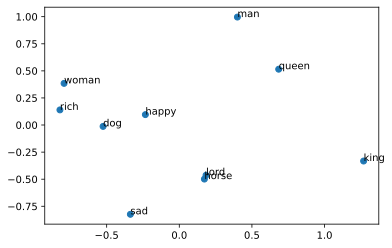

In [25]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

As we can see that **woman and queen are next to each other**. However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

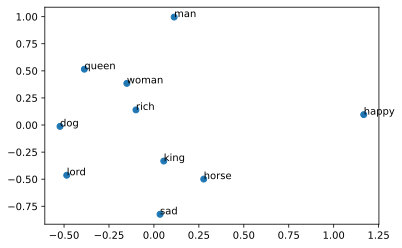

In [27]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()